In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib_detection import load_model, detect_lp, im2single

In [2]:
wpod_net_path = "wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

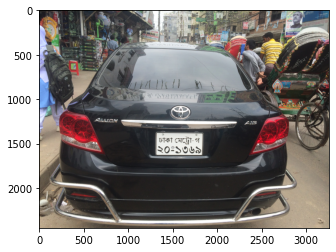

In [174]:
vehicle = plt.imread("/content/noisy.JPG")
plt.imshow(vehicle)

In [175]:
Dmax = 608
Dmin = 288

ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

L , LpImg, lp_type = detect_lp(wpod_net, im2single(vehicle), bound_dim, lp_threshold=0.5)
print("Detect %i plate(s)"%len(LpImg))

Detect 1 plate(s)


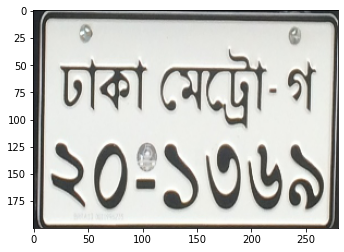

In [176]:
plt.imshow(LpImg[0])

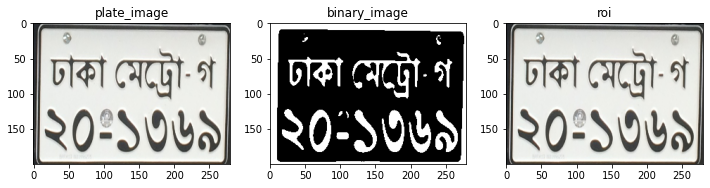

In [177]:
if (len(LpImg)):

    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    roi = LpImg[0]

    # convert to grayscale
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)

    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # plot images
    w,h = 12,7
    fig = plt.figure(figsize=(w,h))
    fig.add_subplot(1,3,1)
    plt.imshow(plate_image)
    plt.title('plate_image')
    
    fig.add_subplot(1,3,2)
    plt.imshow(binary,cmap='gray')
    plt.title('binary_image')
    
    fig.add_subplot(1,3,3)
    plt.imshow(roi,cmap='gray')
    plt.title('roi')  


In [ ]:
# ### Create sort_contours() function to grab the contour of each digit
# def sort_contours(cnts):

#     reverse = False
#     i = 0
#     boundingBoxes = [cv2.boundingRect(c) for c in cnts]
#     (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
#                                         key=lambda b: b[1][i], reverse=reverse))
#     #print(len(cnts))
#     return cnts

In [178]:
def sort_contours(cnts, method="left-to-right"):

    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts)

Text(0.5, 1.0, 'test_roi')

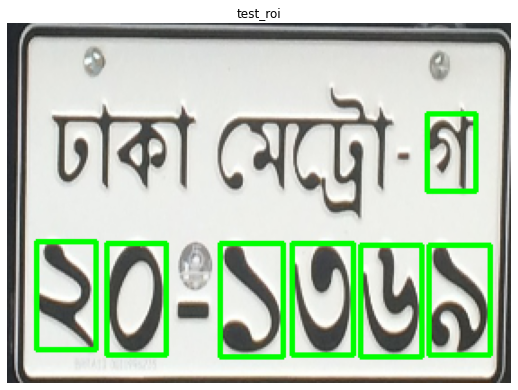

In [180]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

digit_w = 30
digit_h = 60 

plate_info = ""

# crop 
test_roi = roi.copy()
crop_digits = []

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1.5<=ratio<=2: # Only select contour with defined ratio
        if h/roi.shape[0]>=0.196: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_digits.append(curr_num)



fig = plt.figure(figsize=(8,5))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)      
plt.imshow(test_roi)
plt.title('test_roi')
#plt.savefig('grab_digit_contour.png',dpi=300)


In [169]:
from keras.models import model_from_json
from keras.models import Sequential
model = Sequential()
json_file = open('/content/License_plate_nvidia.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/License_plate_nvidia.h5')

In [170]:
digit_names = ('0','1','2','3','4','5','6','7','8','CHA','GA')

def model_predict(image):
    global digit_names
    import numpy as np
    import cv2
    img = np.asarray(image,dtype=np.float32)
    img = cv2.resize(img,(80,224))
    img = img/255
    img = img[np.newaxis,:]
    if len(img.shape)<4:
        img = np.stack((img,)*3, axis=-1)
    max_value = max((model.predict(img)[0]))
    index = np.where(model.predict(img)[0]==max_value)
    return digit_names[int(index[0])]

DHAKA METRO-CHA 0 2 4 0 5 4


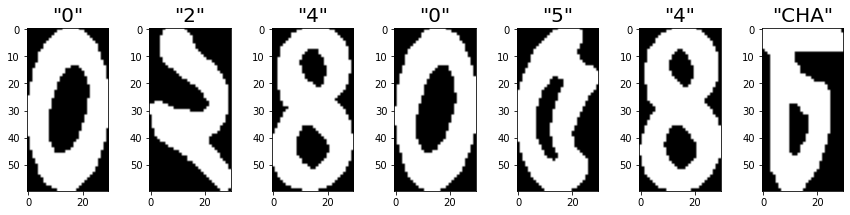

In [171]:
fig = plt.figure(figsize=(15,3))
col = len(crop_digits)
row = 1

final_result = []
val=''
for digit in crop_digits:
    fig.add_subplot(1,col,row)
    title = model_predict(digit)
    final_result.append(title)
    plt.title('"%s"'%title,fontsize=20)
    plt.imshow(digit,cmap='gray')
    row+=1
plt.savefig('digit_crops.png', dpi=300)

for index, value in enumerate(final_result):
  if (value == 'GA') or (value == 'CHA'):
    final_result.pop(index)
    final_result.insert(0,"DHAKA METRO-"+value)

listToStr = ' '.join([str(elem) for elem in final_result]) 
print(listToStr) 

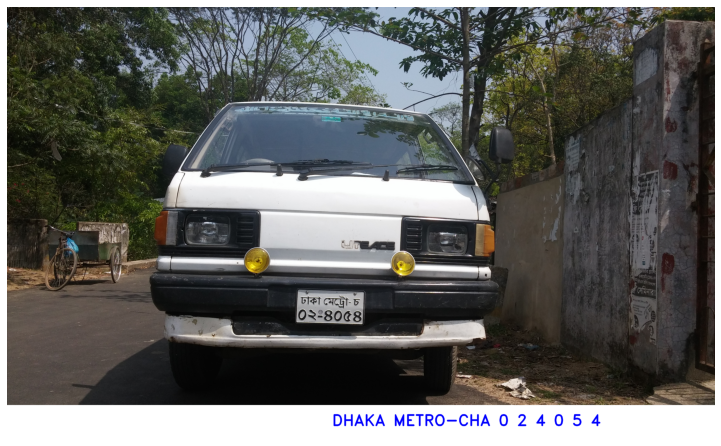

In [172]:
fig = plt.figure(figsize=(10,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

final_image = cv2.copyMakeBorder(src=vehicle,top=0,bottom=200,left=0,right=0,
                                  borderType=cv2.BORDER_CONSTANT, value=[255,255,255])
h,w = final_image.shape[:2]
cv2.putText(final_image,listToStr,(int(w/2-170),int(h-80)),cv2.FONT_HERSHEY_DUPLEX,3,(0,0,255),5,cv2.LINE_AA)
plt.imshow(final_image)
plt.savefig('vehicle_with_prediction.png', dpi=300)